# 랜덤 포레스트

- 부트스트랩

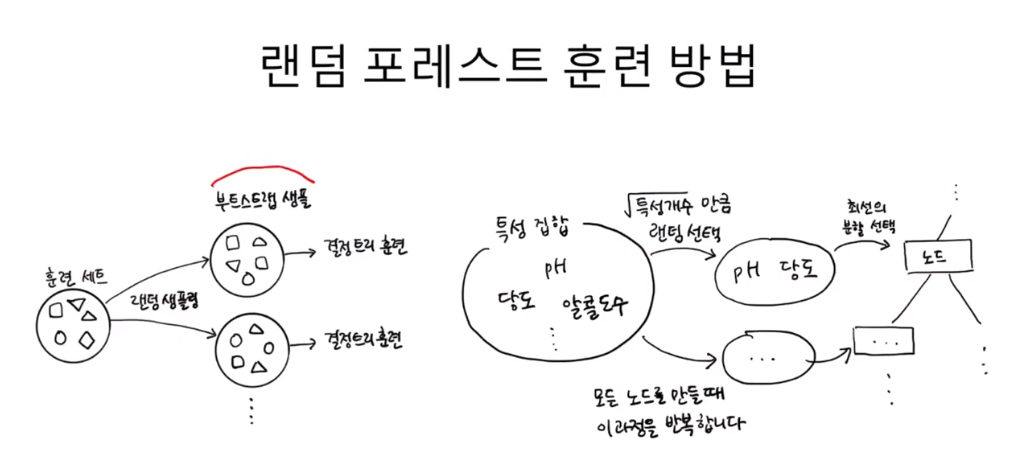

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_jobs=-1,random_state=42)
scores=cross_validate(rf,train_input,train_target, return_train_score=True,n_jobs=-1)
scores

{'fit_time': array([0.30817533, 0.32213831, 0.35903955, 0.49766731, 0.46874595]),
 'score_time': array([0.05285907, 0.05485582, 0.07978654, 0.02792788, 0.03390908]),
 'test_score': array([0.88461538, 0.88942308, 0.90279115, 0.88931665, 0.88642926]),
 'train_score': array([0.9971133 , 0.99663219, 0.9978355 , 0.9973545 , 0.9978355 ])}

In [3]:
print(np.mean(scores['train_score']),np.mean(scores['test_score'])) # 이 테스트 스코어는 검증 데이터 스코어이다.

0.9973541965122431 0.8905151032797809


In [4]:
rf.fit(train_input,train_target)
print(rf.feature_importances_) #당도가 높은것

[0.23167441 0.50039841 0.26792718]


In [5]:
rf=RandomForestClassifier(oob_score=True,n_jobs=-1,random_state=42) 
#oob_score는 무작위 반복랜덤으로 진행하다보니깐 선택안된 데이터들에 대해서 진행하는 것이!
rf.fit(train_input, train_target)
print(rf.oob_score_) #검증데이터 스코어 점수랑 똑같다.

0.8934000384837406


# 엑스트라 트리
- a,b,c, 랜덤하게 분할해서 가장 불순도차이를 나타낸것 찾는다
- 속도가 빠르다. 랜덤포레스트보다 트리 개수가 많아야 좋은 성능이 나온다

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_validate

et=ExtraTreesClassifier(n_jobs=-1,random_state=42)
scores=cross_validate(et,train_input,train_target,return_train_score=True, n_jobs=-1)
scores

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

et.fit(train_input,train_target)
print(et.feature_importances_) #당도가 높은거

0.9974503966084433 0.8887848893166506
[0.20183568 0.52242907 0.27573525]


랜덤~ 부트, 엑스트라~노드분할 무작위

# 그레이디언트 부스팅
- 가장 좋음

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

gb=GradientBoostingClassifier(random_state=42)
scores=cross_validate(gb,train_input,train_target,n_jobs=-1,return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))


gb=GradientBoostingClassifier(n_estimators=500,learning_rate=0.2,random_state=42)
#n_estimators 트리갯수 늘리고, 속도 기본값:0.1 ->0.2
scores=cross_validate(gb,train_input,train_target,n_jobs=-1,return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))


0.8881086892152563 0.8720430147331015
0.9464595437171814 0.8780082549788999


In [8]:
gb.fit(train_input,train_target)
print(gb.feature_importances_)

[0.15872278 0.68010884 0.16116839]


# 히스토그램 기반 그레이디언트 부스팅
- 256개 구간으로 자름(255+1)
- 1개는 누락된값을 넣어줌

In [9]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgb=HistGradientBoostingClassifier(random_state=42)
scores=cross_validate(hgb,train_input,train_target,return_train_score=True,n_jobs=-1)
print(np.mean(scores['train_score']),np.mean(scores['test_score']))

0.9321723946453317 0.8801241948619236


# permutation importance
- 각 열에 맞는 특성(a,b,c, 등)이 있다고 하자
- 먼저 a를 랜덤으로 섞고 성능 평가! -> 물론 성능이 별로다.
- 그 다음 b를 랜덤으로 섞고 성능 평가-> 물론 성능이 별로다.
- 모든 열을 랜덤으로 섞어서 기존 성능과 비교했을 때 차이가 큰 것이 중요도가 크다는 것을 추측할수있다. 기존: 0.9 , a 바꿀때:0.8 ,b 바꿀때: 0.7  차이가 큰 b가 중요도가 크다
- train뿐만 아니라 test도 가능하다.
- 권장하는 방법

In [10]:
from sklearn.inspection import permutation_importance

#훈련데이터
hgb.fit(train_input,train_target)
result=permutation_importance(hgb,train_input,train_target,n_repeats=10)
# n_repeats 기본값은 5
print(result.importances_mean)
# 당도가 중요함을 알수있다. 0.23만큼 떨어진다

[0.09039831 0.23894555 0.08137387]


In [11]:
#테스트데이터

result=permutation_importance(hgb,test_input,test_target,n_repeats=10,random_state=42,n_jobs=-1)
print(result.importances_mean) #ph 3번째는 큰의미가 없어보인다.
hgb.score(test_input,test_target) 

[0.05969231 0.20238462 0.049     ]


0.8723076923076923

# XGBoost vs LightGBM

- 캐글에서 많이 사용
- LightGBM 히스토그램 지원

In [12]:
pip install xgboost

You should consider upgrading via the 'C:\Users\82109\anaconda3\python.exe -m pip install --upgrade pip' command.


In [13]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\82109\anaconda3\python.exe -m pip install --upgrade pip' command.


In [14]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9555033709953124 0.8799326275264677


In [15]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.935828414851749 0.8801251203079884


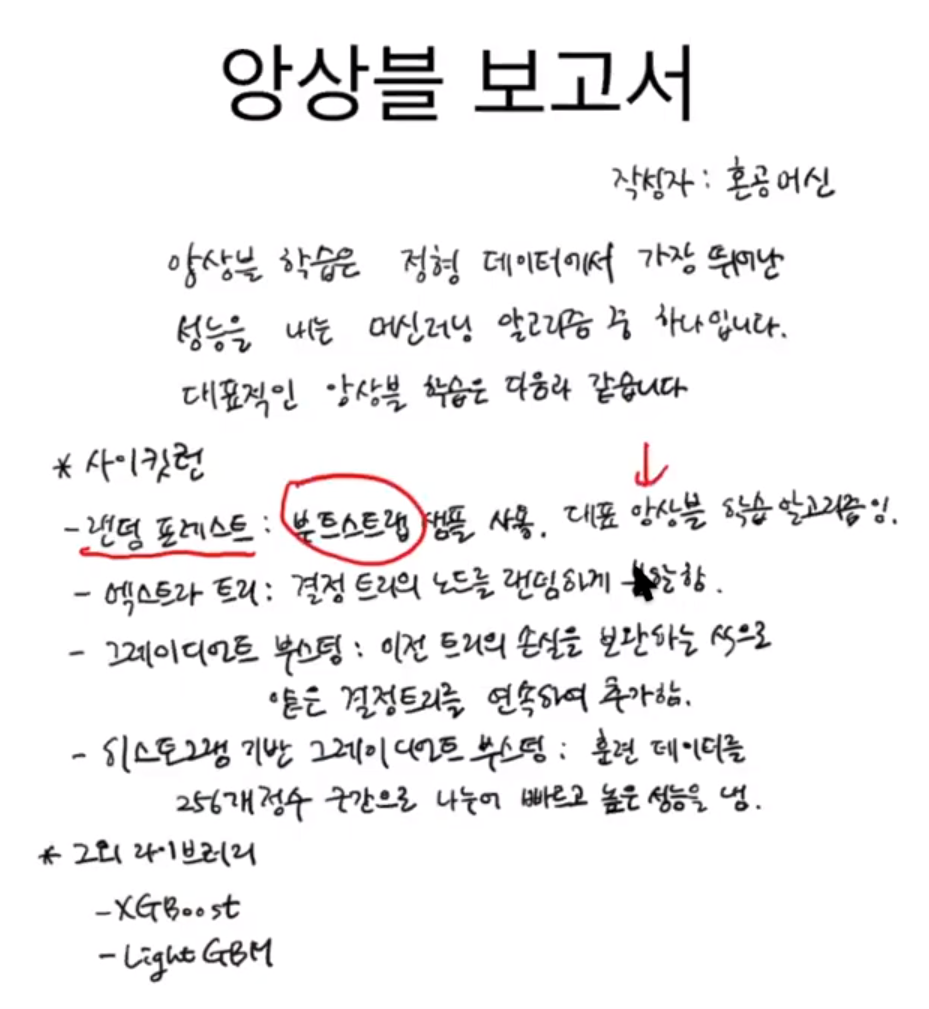